In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from PIL import Image, ImageOps

from tqdm.notebook import tqdm, tnrange
import matplotlib.pyplot as plt
import numpy as np

import os
import glob

In [6]:
# Set up cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'Device Name: {torch.cuda.get_device_name(0)}')

Device: cuda:0
Device Name: GeForce GTX 1650 Ti


In [7]:
# Fucntion for visualizing file structure
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        if len(files) > 0:
            print('{}({} files)'.format(subindent, len(files)))

In [8]:
# Select whether you are running on Google Collab ('collab') or locally ('local')
system = 'local'
s = os.sep

if system == 'collab':
    # Mount google drive
    from google.colab import drive
    drive.mount(f'{s}content{s}drive')

    root_path = f'{s}content{s}drive{s}My Drive{s}Collab Data{s}Chest X-Ray{s}chest_xray'
    
elif system == 'local':
    root_path = f'../{s}data{s}chest_xray'
else:
    root_path = 'NULL'
    
    
if os.path.isdir(root_path):
    print('Data Directory Structure:\n')
    list_files(root_path)
else:
    print('Data folder doesnt exist')

Data Directory Structure:

chest_xray/
    val/
        NORMAL/
            (8 files)
        PNEUMONIA/
            (8 files)
    train/
        NORMAL/
            (1341 files)
        PNEUMONIA/
            (3875 files)
    __MACOSX/
        (1 files)
        chest_xray/
            (3 files)
            val/
                (1 files)
                NORMAL/
                    (9 files)
                PNEUMONIA/
                    (9 files)
            train/
                (3 files)
                NORMAL/
                    (1342 files)
                PNEUMONIA/
                    (3876 files)
            test/
                (3 files)
                NORMAL/
                    (234 files)
                PNEUMONIA/
                    (390 files)
    chest_xray/
        (1 files)
        val/
            (1 files)
            NORMAL/
                (9 files)
            PNEUMONIA/
                (9 files)
        train/
            (1 files)
            NORMAL/
       

In [9]:
classes = { 'NORMAL': 0.0, 'PNEUMONIA': 1.0 }
classes_inv = ['NORMAL', 'PNEUMONIA']
class XrayDataset(Dataset):
  '''
  Args:
    root_dir : path to the directory which contains the NORMAL/PNEMONIA split
    transform : transforms to be applied to each image
  '''
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.samples = []
    self.transform = transform

    for label in os.listdir(root_dir):
      label_folder = os.path.join(root_dir, label)
      
      for image_path in os.listdir(label_folder):
        self.samples.append((os.path.join(label_folder, image_path), label))

  def __len__(self):
        return len(self.samples)

  def __getitem__(self, idx):
    
    if torch.is_tensor(idx):
      idx = idx.tolist()

    im_path, label = self.samples[idx]

    im = Image.open(im_path)
    
    if im.mode == 'L':
      im = im.convert('RGB')
    
    if self.transform:
      im = self.transform(im)
      
    classes = {'PNEUMONIA': 1.0, 'NORMAL': 0.0}
    return {'image': im, 'class': classes[label], 'path': im_path}


In [10]:
bs = 64

transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train = XrayDataset(os.path.join(root_path, 'train'), transform=transform)
training_samples = len(train)
dl = DataLoader(train, 
                batch_size=bs,
                shuffle=True)

test = XrayDataset(os.path.join(root_path, 'test'), transform=transform)
test_samples = len(test)
test_dl = DataLoader(test, 
                batch_size=bs,
                shuffle=True)

val = XrayDataset(os.path.join(root_path, 'val'), transform=transform)
val_samples = len(val)
val_dl = DataLoader(val, 
                batch_size=bs,
                shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


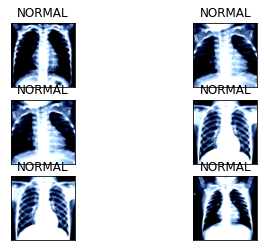

In [11]:
# Show some of the images
b=0

f, axarr = plt.subplots(3,2)

for i in range(3):
    for j in range(2):
        ax = axarr[i,j]
        ax.imshow(test[i + j]['image'].permute(1,2,0))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(classes_inv[int(test[i+j]['class'])])
plt.show()

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(71 * 71 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 71 * 71 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [13]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=80656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
def acc(outputs, labels, threshold, decimals=1, div=True):
    rounded_outputs = torch.where(outputs > threshold, 
                                    torch.ones(outputs.size()).to(device), 
                                    torch.zeros(outputs.size()).to(device))
    acc = torch.eq(rounded_outputs, labels.float()).float().sum().item()
    if div:
        return round(acc / outputs.size()[0], decimals)
    else:
        return acc

In [16]:
# Validation loop

def val():
    correct = 0
    samples = 0
    for i, data_dic in enumerate(val_dl):
        data, labels = data_dic['image'], data_dic['class']
        data, labels = data.to(device), labels.to(device)
        
        outs = net(data).view(-1)
        
        correct += acc(outs, labels, 0.5, 1, False)
        samples += outs.size()[0]
    return correct/samples

In [17]:
# Test loop

def test():
    correct = 0
    samples = 0
    for i, data_dic in enumerate(test_dl):
        data, labels = data_dic['image'], data_dic['class']
        data, labels = data.to(device), labels.to(device)
        
        outs = net(data).view(-1)
        
        correct += acc(outs, labels, 0.5, 1, False)
        samples += outs.size()[0]
    return correct/samples

In [18]:
# Training loop
losses = []
moving_average_loss = []
running_losses = []
accuracy = []
moving_average_acc = []
running_accs = []


moving_win = 20

def train():
    running_loss = 0.0
    running_acc = 0.0

    epochs = 5
    threshold = 0.5

    # batches per epoch
    batches = training_samples//bs
    if training_samples % bs != 0: batches += 1
    for j in range(epochs):
        print(f'Epoch {j+1}:')
        with tqdm(bar_format='{desc}') as batch_t:
            with tqdm(enumerate(dl), total=batches) as running_t: 
                running_t.set_description('[epoch, batch] loss: ### acc: ### ')
                for i, data_dic in running_t: 
                  optimizer.zero_grad()

                  data, labels = data_dic['image'], data_dic['class']
                  data, labels = data.to(device), labels.to(device)

                  outputs = net(data).view(-1)

                  loss = criterion(outputs, labels.float())
                  loss.backward()
                  optimizer.step()

                  calced_acc = acc(outputs,labels,threshold,3)
                  running_loss += loss.item()
                  running_acc += calced_acc
                  
                  # Collect losses and accuracies
                  # Batch
                  losses.append(loss.item())
                  accuracy.append(calced_acc) 
                  
                  # Running Average
                  if i == 0 and j == 0:
                    running_losses.append(running_loss)
                    running_accs.append(running_acc)
                  else:
                    running_losses.append(running_loss / (j*batches + i + 1))
                    running_accs.append(running_acc / (j*batches + i + 1))
    
                  # Moving Average
                  if len(losses) < 20:
                    moving_average_loss.append(sum(losses)/len(losses))
                    moving_average_acc.append(sum(accuracy)/len(accuracy))
                  else:
                    moving_average_loss.append(sum(losses[-20:])/moving_win)
                    moving_average_acc.append(sum(accuracy[-20:])/moving_win)

                  batch_t.set_description('Batch %d:  loss: %.3f acc: %.3f' %(i + 1, loss, calced_acc))
                  running_t.set_description('Moving Average: loss: %.3f acc: %.3f'
                                    %(moving_average_loss[-1], moving_average_acc[-1]))
                    
        print('Epoch %d validation accuracy: %.3f' % (j+1, val()))

In [19]:
# We can graph accuracy and loss here
def plot(graph='Moving Average'):
    
    if graph == 'Moving Average':
        l = moving_average_loss
        a = moving_average_acc
    elif graph == 'Batch':
        l = losses
        a = accuracy
    elif graph == 'Running Average':
        l = running_losses
        a = running_accs
    else:
        print('This is an unsupported graph type. Please try again')
        return None
    
    
    plt.plot(l, label="MSE Loss")
    plt.plot(a, label="Accuracy")
    
    plt.xlabel('Batch')
    plt.ylabel(graph)
    plt.legend()
    plt.show()


In [20]:
train()

Epoch 1:


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1 validation accuracy: 0.625
Epoch 2:


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2 validation accuracy: 0.750
Epoch 3:


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3 validation accuracy: 0.688
Epoch 4:


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 4 validation accuracy: 0.750
Epoch 5:


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 5 validation accuracy: 0.688


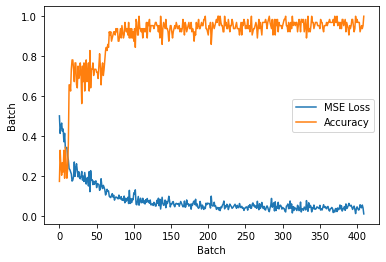

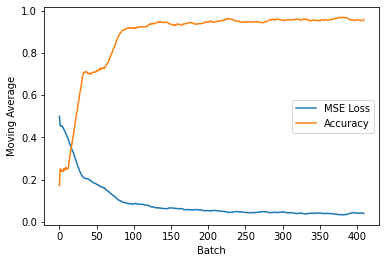

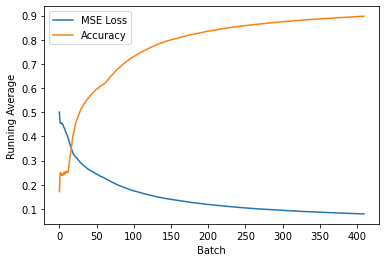

In [21]:
for graph_type in ['Batch', 'Moving Average', 'Running Average']:
    plot(graph=graph_type)

In [22]:
print(test())

0.7788461538461539
